# MNIST Classification

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
import os
import math

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

### for notebook users
%matplotlib inline

## Preprocessing & Inspecting

### Defining Dataloader
tensorflow.keras.utils.Sequence를 상속받아서 Dataloader라는 class를 생성

In [2]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

### Generating Datasets

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

### Hyperparametrization을 하면 맨 아래로 이동될 변수들
### 아직 Modeling이 되지 않아 임시로 여기에 두겠습니다.
batch_size = 128
num_classes = len(np.unique(y_train))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


### Preprocessing

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32") / (2^8 - 1)
X_test = X_test.astype("float32") / (2^8 - 1)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [5]:
train_loader = Dataloader(X_train, y_train, batch_size, shuffle=True)
test_loader = Dataloader(X_test, y_test, batch_size, shuffle=False)

### Dataset Inspecting

In [6]:
### 임시로 한 개의 minibatch를 돌려보는 상황

examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128, 10)
Data  : (128, 28, 28, 1)


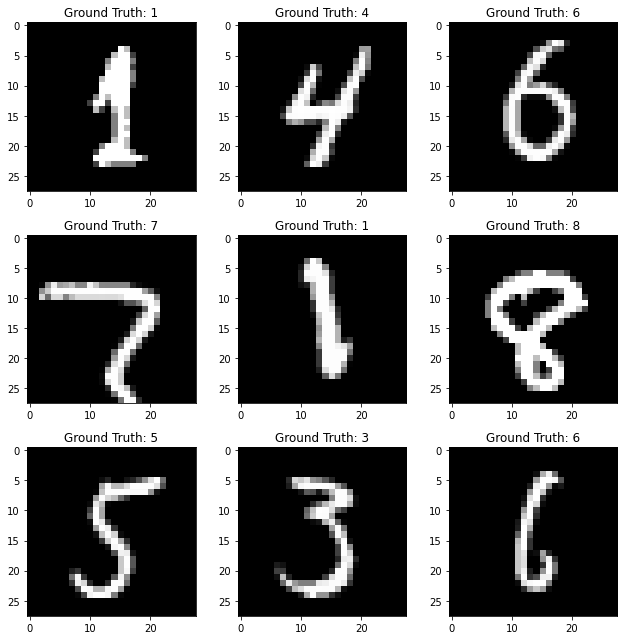

In [7]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(example_data[i], cmap="gray", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

## Hypothesis Modeling / Defining Loss Function

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_uniform", input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))   # 중요

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [9]:
### compile

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

## TRAINING

In [10]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
375/375 [==============================] - 34s 91ms/step - loss: 1.0533 - accuracy: 0.9071 - val_loss: 0.1441 - val_accuracy: 0.9648
Epoch 2/5
375/375 [==============================] - 34s 90ms/step - loss: 0.0954 - accuracy: 0.9743 - val_loss: 0.0825 - val_accuracy: 0.9787
Epoch 3/5
375/375 [==============================] - 34s 92ms/step - loss: 0.0665 - accuracy: 0.9823 - val_loss: 0.1195 - val_accuracy: 0.9737
Epoch 4/5
375/375 [==============================] - 34s 91ms/step - loss: 0.0484 - accuracy: 0.9874 - val_loss: 0.0789 - val_accuracy: 0.9839
Epoch 5/5
375/375 [==============================] - 35s 92ms/step - loss: 0.0399 - accuracy: 0.9899 - val_loss: 0.0912 - val_accuracy: 0.9852


## EVALUATION

In [11]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val loss")
    loss_ax.set_xlabel("epoch")
    loss_ax.set_ylabel("loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("loss")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

baseline accuracy


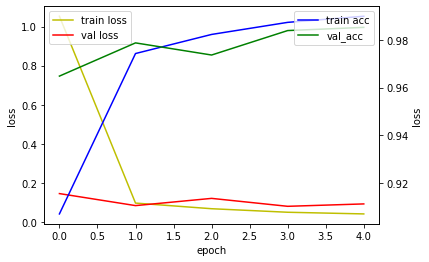

None


In [12]:
print("baseline accuracy")
print(acc_loss_plot(hist))

In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

Test Loss: 0.07226552814245224
Test Accuracy: 0.9837999939918518
